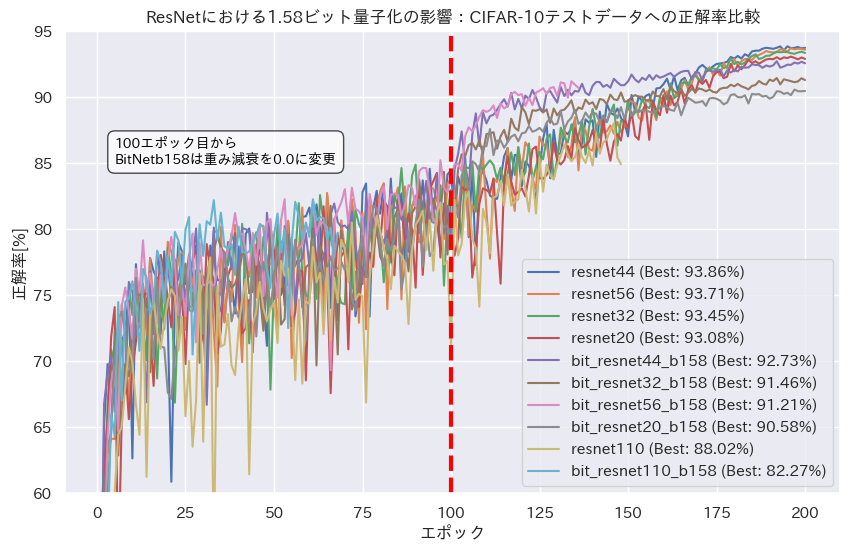

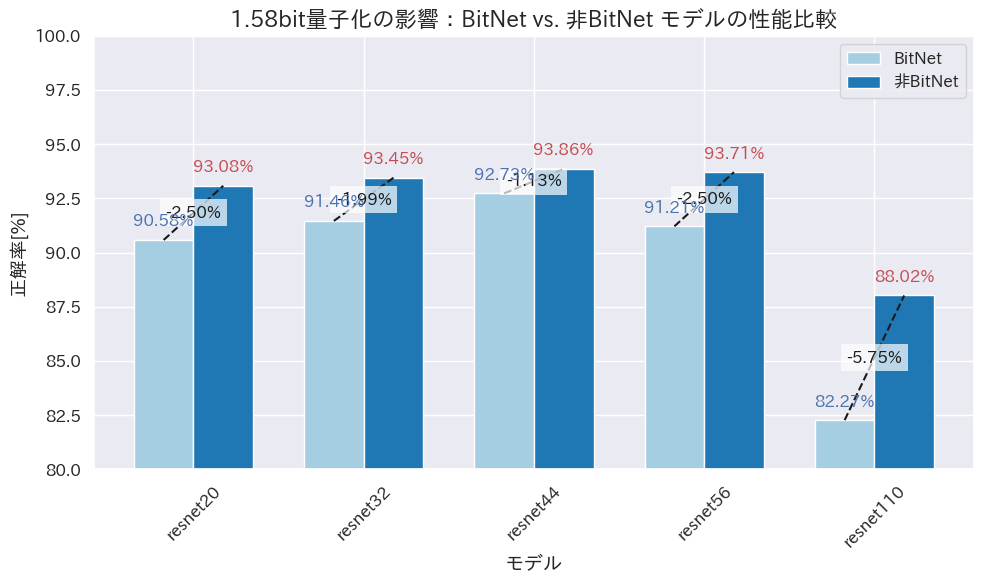

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import seaborn as sns
import re

class ModelAnalyzer:
    def __init__(self, pretrain_dir):
        self.pretrain_dirs = [f"{pretrain_dir}/{d}/" for d in os.listdir(pretrain_dir) if os.path.isdir(f"{pretrain_dir}/{d}")]

    def extract_scalar_arrays(self, scalar_events):
        return np.array([event.wall_time for event in scalar_events]), np.array([event.step for event in scalar_events]), np.array([event.value for event in scalar_events])

    def plot_model_accuracy(self):
        plt.figure(figsize=(10, 6))

        # 各モデルのログデータを読み込み、最高精度を取得しリストに保存
        model_accuracy = []
        for pretrain_dir in self.pretrain_dirs:
            model_name = os.path.basename(os.path.normpath(pretrain_dir))
            accumulator = EventAccumulator(pretrain_dir)
            accumulator.Reload()
            wall_times, steps, values = self.extract_scalar_arrays(accumulator.Scalars("test_top1"))
            max_accuracy = max(values)  # 最高精度を取得
            model_accuracy.append((model_name, max_accuracy))

        # 精度の降順にソート
        model_accuracy.sort(key=lambda x: x[1], reverse=True)

        # ソートされた順番に従ってプロット
        for model_name, _ in model_accuracy:
            accumulator = EventAccumulator(os.path.join("runs/pre-train", model_name))
            accumulator.Reload()
            wall_times, steps, values = self.extract_scalar_arrays(accumulator.Scalars("test_top1"))
            plt.plot(steps, values, label=f"{model_name} (Best: {max(values):.2f}%)")

        # タイトルや軸ラベルを設定
        plt.title("ResNetにおける1.58ビット量子化の影響：CIFAR-10テストデータへの正解率比較")
        plt.xlabel("エポック")
        plt.ylabel("正解率[%]")
        plt.ylim(60, 95)

        # 凡例を表示
        plt.legend()

        # グリッドを表示
        plt.grid(True)

        plt.axvline(x=100, color="red", linestyle="--", linewidth=3)
        bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.7)
        plt.text(
            5,
            85,
            "100エポック目から\nBitNetb158は重み減衰を0.0に変更",
            fontsize=10,
            color="black",
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=1, alpha=0.7),
        )

        # グラフを保存して表示
        plt.savefig("pre-train.svg")
        plt.show()
        return model_accuracy



    def extract_number(self, model_name):
        match = re.search(r'\d+', model_name)
        return int(match.group()) if match else None

    def plot_model_comparison(self, model_accuracy):
        model_accuracy.sort(key=lambda x: x[1], reverse=True)  # モデルを性能順にソート

        bitnet_accuracy = [(model, accuracy) for model, accuracy in model_accuracy if "bit" in model]
        non_bitnet_accuracy = [(model, accuracy) for model, accuracy in model_accuracy if "bit" not in model]

        bitnet_accuracy.sort(key=lambda x: self.extract_number(x[0]))
        non_bitnet_accuracy.sort(key=lambda x: self.extract_number(x[0]))

        bitnet_models, bitnet_values = zip(*bitnet_accuracy)
        non_bitnet_models, non_bitnet_values = zip(*non_bitnet_accuracy)

        sns.set(font='IPAexGothic')
        plt.figure(figsize=(10, 6))

        bar_width = 0.35
        index = np.arange(len(non_bitnet_models))

        palette = sns.color_palette("Paired")

        bitnet_bars = plt.bar(index, bitnet_values, bar_width, label='BitNet', color=palette[0])
        non_bitnet_bars = plt.bar(index + bar_width, non_bitnet_values, bar_width, label='非BitNet', color=palette[1])

        plt.xlabel('モデル', fontsize=14, fontweight='bold')
        plt.ylabel('正解率[%]', fontsize=14, fontweight='bold')
        plt.title("1.58bit量子化の影響：BitNet vs. 非BitNet モデルの性能比較", fontsize=16, fontweight='bold')
        plt.xticks(index + bar_width / 2, non_bitnet_models, rotation=45, ha='center', fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12)

        for i in range(len(bitnet_values)):
            plt.plot([i, i + bar_width], [bitnet_values[i], non_bitnet_values[i]], 'k--')
            performance_diff = bitnet_values[i] - non_bitnet_values[i]
            plt.text(i + bar_width / 2, (bitnet_values[i] + non_bitnet_values[i]) / 2, f'{performance_diff:.2f}%', 
                     ha='center', va='center', color='k', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

        for i, value in enumerate(bitnet_values):
            plt.text(i, value + 0.5, f'{value:.2f}%', ha='center', va='bottom', color='b', fontsize=12, fontweight='bold')
        for i, value in enumerate(non_bitnet_values):
            plt.text(i + bar_width, value + 0.5, f'{value:.2f}%', ha='center', va='bottom', color='r', fontsize=12, fontweight='bold')

        plt.ylim(80, 100)
        plt.tight_layout()
        plt.show()

analyzer = ModelAnalyzer("runs/pre-train/")
model_accuracy = analyzer.plot_model_accuracy()
analyzer.plot_model_comparison(model_accuracy)
